## Homework 4 - Visualizing Fire Scars Through False Color - Pt 2

Author: Eva Newby

Website for instructions: https://meds-eds-220.github.io/MEDS-eds-220-course/assignments/assignment4.html

Link to my github repository: https://github.com/evajnewby/eds220-hwk4

Rubric: https://docs.google.com/document/d/1-Zm731BLVCs1MXHT5R1H9rr6uvcwHnMZQ2q8xkQ_fWM/edit?tab=t.0

Added data folder to gitignore

### About

The purpose of this assignment is to create a false color image of southern Santa Barbara county using landsat data, and overlay the 2017 Thomas fire boundary GeoJSON (created in pt 1 of this assignment). The goal is to see if the false color imagery illuminates the 2017 Thomas fire scar, and if that matches well with the boundary. 

Additionally, practice with the `rioxarray` package and working with geoJSON files are important aspects of this assignment.

#### The Dataset
The data is from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite, and contains several bands (red, green, blue, near-infrared and shortwave infrared). This dataset was retrieved from the Microsoft Planetary Computer data catalogue and pre-processed to remove data outside land and coarsen the spatial resolution. 

Data reference:
Microsoft. (n.d.). Landsat C2 L2 dataset. Planetary Computer. Retrieved November 19, 2024, from https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

In [1]:
# Load Packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import rasterio
import numpy as np
from shapely.geometry import box

## Import Landsat Data (using server file path)

In [2]:
# Get current working directory
os.getcwd()

'/Users/ejnewby/MEDS/EDS-220/eds220-hwk4'

In [3]:
# Import .nc file using rioxr.open_rasterio
fp2 = os.path.join('/', 'Users', 'ejnewby', 'MEDS', 'EDS-220', 'eds220-hwk4', 'data','landsat8-2018-01-26-sb-simplified.nc')
landsat = rioxr.open_rasterio(fp2)

#### Explore data

In [4]:
# View the landsat dataset
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

In [5]:
# View landsat dimensions
landsat.dims

FrozenMappingWarningOnValuesAccess({'band': 1, 'x': 870, 'y': 731})

Data summary:
- The variables are red, green, blue, nir08 (nir-infrared), and swir22(short-wave infrared).
- The dimensions are  1 spectral band, 870 rows (height), and 731 columns (width)

## True Color Image

To create a true color image, the band dimensionss will need to be dropped. 

In [6]:
# Drop the band dimension of the data using squeeze() and drop_vars().
landsat = landsat.squeeze().drop_vars('band')

In [7]:
# Confirm drop and squeeze
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (x: 870, y: 731)
Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float64 5MB ...
    green        (y, x) float64 5MB ...
    blue         (y, x) float64 5MB ...
    nir08        (y, x) float64 5MB ...
    swir22       (y, x) float64 5MB ...

Next, the red, green, and blue variables will need to be selected, converted to an array, and plotted. In order for a true color image to show, the robust parameter within `.imshow()` will need to be edited to True.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


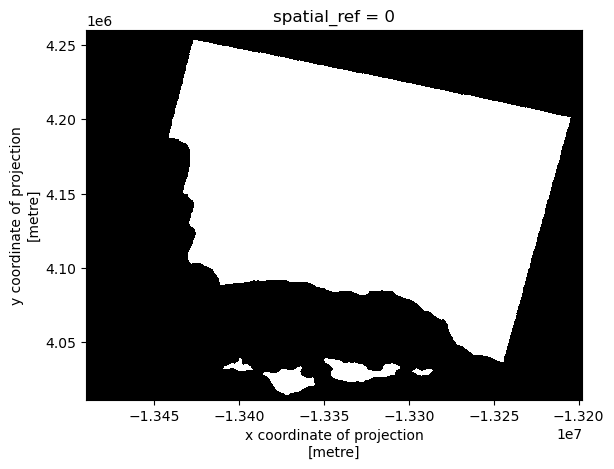

In [17]:
# Select red, green, and blue bands, convert to an array using `.to_array()`, and plot using `.imshow()`

xr.Dataset(landsat[['red','green','blue']]).to_array().plot.imshow()

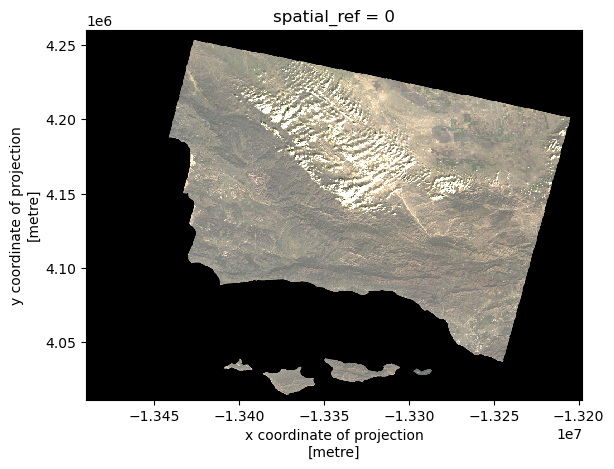

In [18]:
# Adjust scale by setting robust parameter to true.
xr.Dataset(landsat[['red','green','blue']]).to_array().plot.imshow(robust=True)

#### Compare the ouputs
The first part gives a black and white output, while the second part gives the true colors. This is due to the robust parameter, which adjusts the color scale using data percentiles instead of minimum and maximum values, therefore excluding some extreme outliers that were influencing the scaling of the image as observed in part a. 

## False Color Image

To create a false color image for the true color image above, the short-wave infrared, near wave infrared, and red variables will need to be plotted in that order. 

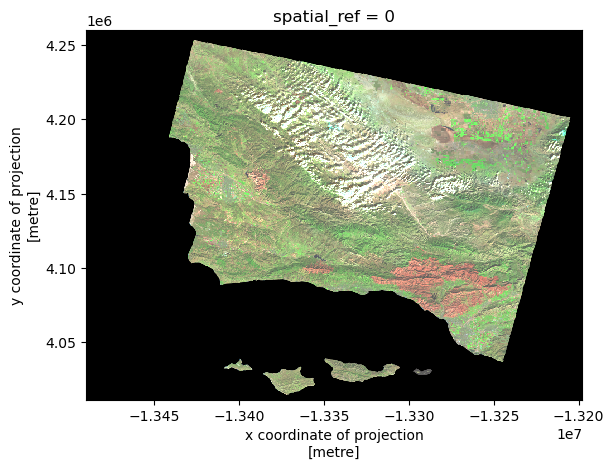

In [19]:
# Create a false color image by plotting swir22, nir08, and red. 
landsat_false = xr.Dataset(landsat[['swir22','nir08','red']]).to_array().plot.imshow(robust = True)

## Map

Now that we have a false color image with a fire scar in the southwestern section of the image, let's load in the 2017 Thomas fire perimeter GeoJson ontop. From this map, we can observe how closely the fire perimeter matches with the fire scar. 

In [20]:
# Read-in thomas fire data from other notebook
fp3 = os.path.join('/', 'Users', 'ejnewby', 'MEDS', 'EDS-220', 'eds220-hwk4', 'data','thomas.geojson')
thomas = gpd.read_file(fp3)

In [21]:
# Check CRS of thomas fire boundary data
print(f"{'The CRS of the landsat data is':<27}{thomas.crs}")

The CRS of the landsat data isEPSG:3857


In [22]:
# Check CRS for landsat data
print(f"{'The CRS of the landsat data is':<27}{landsat.rio.crs}")

The CRS of the landsat data isEPSG:3857


In [23]:
# Change landsat to Projected CRS: EPSG:3857, since that matches the Thomas fire bounday
landsat = landsat.rio.reproject("EPSG:3857")

# Verify change
print(f"{'The CRS of the landsat data is':<27}{landsat.rio.crs}")
print(f"{'The CRS of the landsat data is':<27}{thomas.crs}")

The CRS of the landsat data isEPSG:3857
The CRS of the landsat data isEPSG:3857


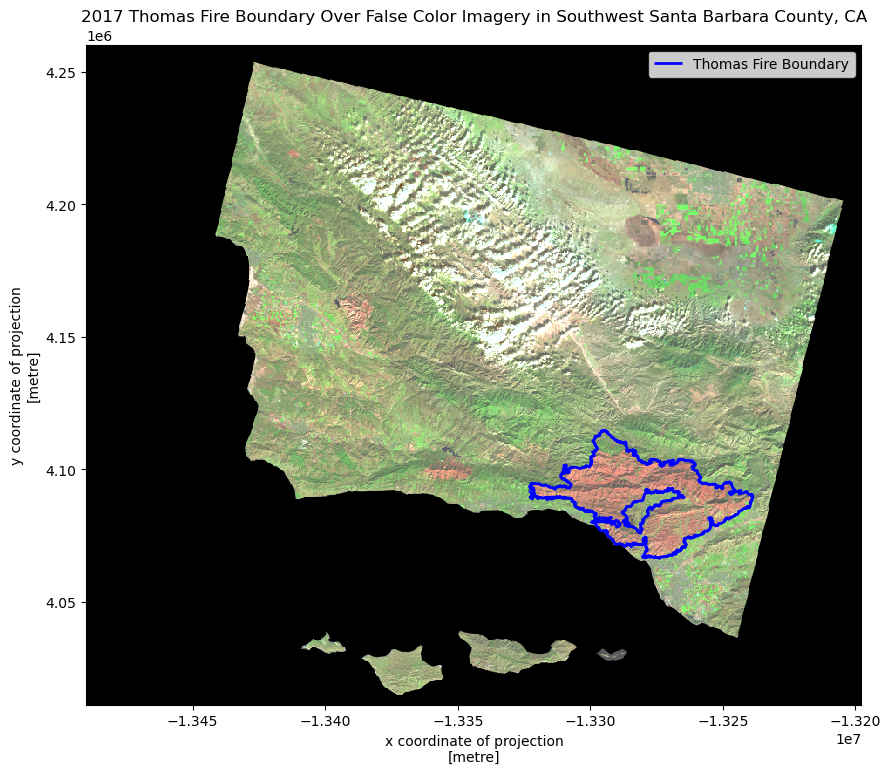

In [24]:
# Plot Landsat and Fire boundary data
fig, ax = plt.subplots(figsize = (10, 10))

landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax = ax, robust = True)

thomas.boundary.plot(ax = ax, edgecolor = 'blue', linewidth = 2, label="Thomas Fire Boundary")

ax.legend()

ax.set_title('2017 Thomas Fire Boundary Over False Color Imagery in Southwest Santa Barbara County, CA',
             fontsize = 12)

plt.show()

### Map Description:

The map above shows how false color imagery is being used to greater illuminate the 2017 Thomas fire boundary. As areas that were burned more recently will have different and younger vegetation (also more likely to have non-native species after burning), the chlorophyll content of the vegetation differences will show more drastically in a false color image than a true color image as they reflect different wavelengths back, which cannot be seen in the visible spectrum. One can see how the 2017 Thomas fire boundary matches up pretty closely with the burned areas showing up as orange-red. 